In [82]:
%matplotlib inline

In [83]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.base import BaseEstimator, TransformerMixin
# from pandas_profiling import ProfileReport
from pathlib import Path
import missingno as msno
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import tkinter
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import  cross_val_score, cross_val_predict
import joblib

# Import DataFrames

In [84]:
full_data = pd.read_csv("./datasets/application_record.csv")
credit_data = pd.read_csv("./datasets/credit_record.csv")

In [175]:
full_data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,"$427,500.00",Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,$2.00
1,5008805,M,Y,Y,0,"$427,500.00",Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,$2.00
2,5008806,M,Y,Y,0,"$112,500.00",Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,$2.00
3,5008808,F,N,Y,0,"$270,000.00",Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,$1.00
4,5008809,F,N,Y,0,"$270,000.00",Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,$1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,"$135,000.00",Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,$1.00
438553,6840222,F,N,N,0,"$103,500.00",Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,$1.00
438554,6841878,F,N,N,0,"$54,000.00",Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,$1.00
438555,6842765,F,N,Y,0,"$72,000.00",Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,$2.00


In [176]:
begin_month = pd.DataFrame(credit_data.groupby("MONTHS_BALANCE").agg(min))
begin_month = begin_month.rename(columns={'MONTHS_BALANCE':'Account age'})

credit_full_data = pd.merge(full_data, begin_month, how="left", on="ID")

credit_data["dep_value"] = None
credit_data['dep_value'][credit_data['STATUS'] =='2']='Yes'
credit_data['dep_value'][credit_data['STATUS'] =='3']='Yes'
credit_data['dep_value'][credit_data['STATUS'] =='4']='Yes'
credit_data['dep_value'][credit_data['STATUS'] =='5']='Yes' 
cpunt = credit_data.groupby('ID').count()
cpunt = cpunt[['dep_value']]
cpunt['dep_value'][cpunt['dep_value'] > 0] = 'Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0] = 'No'
cpunt = cpunt[['dep_value']]

credit_full_data = pd.merge(credit_full_data, cpunt, how = 'inner', on = 'ID')
credit_full_data["Is high risk"] = credit_full_data['dep_value']    #Chỉ số đánh giá tín dụng

credit_full_data.loc[credit_full_data["Is high risk"] == 'Yes', 'Is high risk'] = 1
credit_full_data.loc[credit_full_data["Is high risk"] == 'No', 'Is high risk'] = 0
credit_full_data.drop('dep_value',axis=1,inplace= True)


c:\Users\Minh\Desktop\Credit-card-approval-prediction-classification-main\MIM Python\venv\lib\site-packages\pandas\core\apply.py:169: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  return getattr(obj, f)()


### Reaname featrures

In [177]:
credit_full_data = credit_full_data.rename(columns={
    'CODE_GENDER':'Gender',
    'FLAG_OWN_CAR':'Has a car',
    'FLAG_OWN_REALTY':'Has a property',
    'CNT_CHILDREN':'Children count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment status',
    'NAME_EDUCATION_TYPE':'Education level',
    'NAME_FAMILY_STATUS':'Marital status',
    'NAME_HOUSING_TYPE':'Dwelling',
    'DAYS_BIRTH':'Age',
    'DAYS_EMPLOYED': 'Employment length',
    'FLAG_MOBIL': 'Has a mobile phone',
    'FLAG_WORK_PHONE': 'Has a work phone',
    'FLAG_PHONE': 'Has a phone',
    'FLAG_EMAIL': 'Has an email',
    'OCCUPATION_TYPE': 'Job title',
    'CNT_FAM_MEMBERS': 'Family member count',
    'Account age': 'Account age'
})

In [178]:
credit_full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   Gender               36457 non-null  object 
 2   Has a car            36457 non-null  object 
 3   Has a property       36457 non-null  object 
 4   Children count       36457 non-null  int64  
 5   Income               36457 non-null  float64
 6   Employment status    36457 non-null  object 
 7   Education level      36457 non-null  object 
 8   Marital status       36457 non-null  object 
 9   Dwelling             36457 non-null  object 
 10  Age                  36457 non-null  int64  
 11  Employment length    36457 non-null  int64  
 12  Has a mobile phone   36457 non-null  int64  
 13  Has a work phone     36457 non-null  int64  
 14  Has a phone          36457 non-null  int64  
 15  Has an email         36457 non-null 

In [90]:
full_data.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,"$438,557.00","$438,557.00","$438,557.00","$438,557.00","$438,557.00","$438,557.00","$438,557.00","$438,557.00","$438,557.00","$438,557.00"
mean,"$6,022,176.27",$0.43,"$187,524.29","$-15,997.90","$60,563.68",$1.00,$0.21,$0.29,$0.11,$2.19
std,"$571,637.02",$0.72,"$110,086.85","$4,185.03","$138,767.80",$0.00,$0.40,$0.45,$0.31,$0.90
min,"$5,008,804.00",$0.00,"$26,100.00","$-25,201.00","$-17,531.00",$1.00,$0.00,$0.00,$0.00,$1.00
25%,"$5,609,375.00",$0.00,"$121,500.00","$-19,483.00","$-3,103.00",$1.00,$0.00,$0.00,$0.00,$2.00
50%,"$6,047,745.00",$0.00,"$160,780.50","$-15,630.00","$-1,467.00",$1.00,$0.00,$0.00,$0.00,$2.00
75%,"$6,456,971.00",$1.00,"$225,000.00","$-12,514.00",$-371.00,$1.00,$0.00,$1.00,$0.00,$3.00
max,"$7,999,952.00",$19.00,"$6,750,000.00","$-7,489.00","$365,243.00",$1.00,$1.00,$1.00,$1.00,$20.00


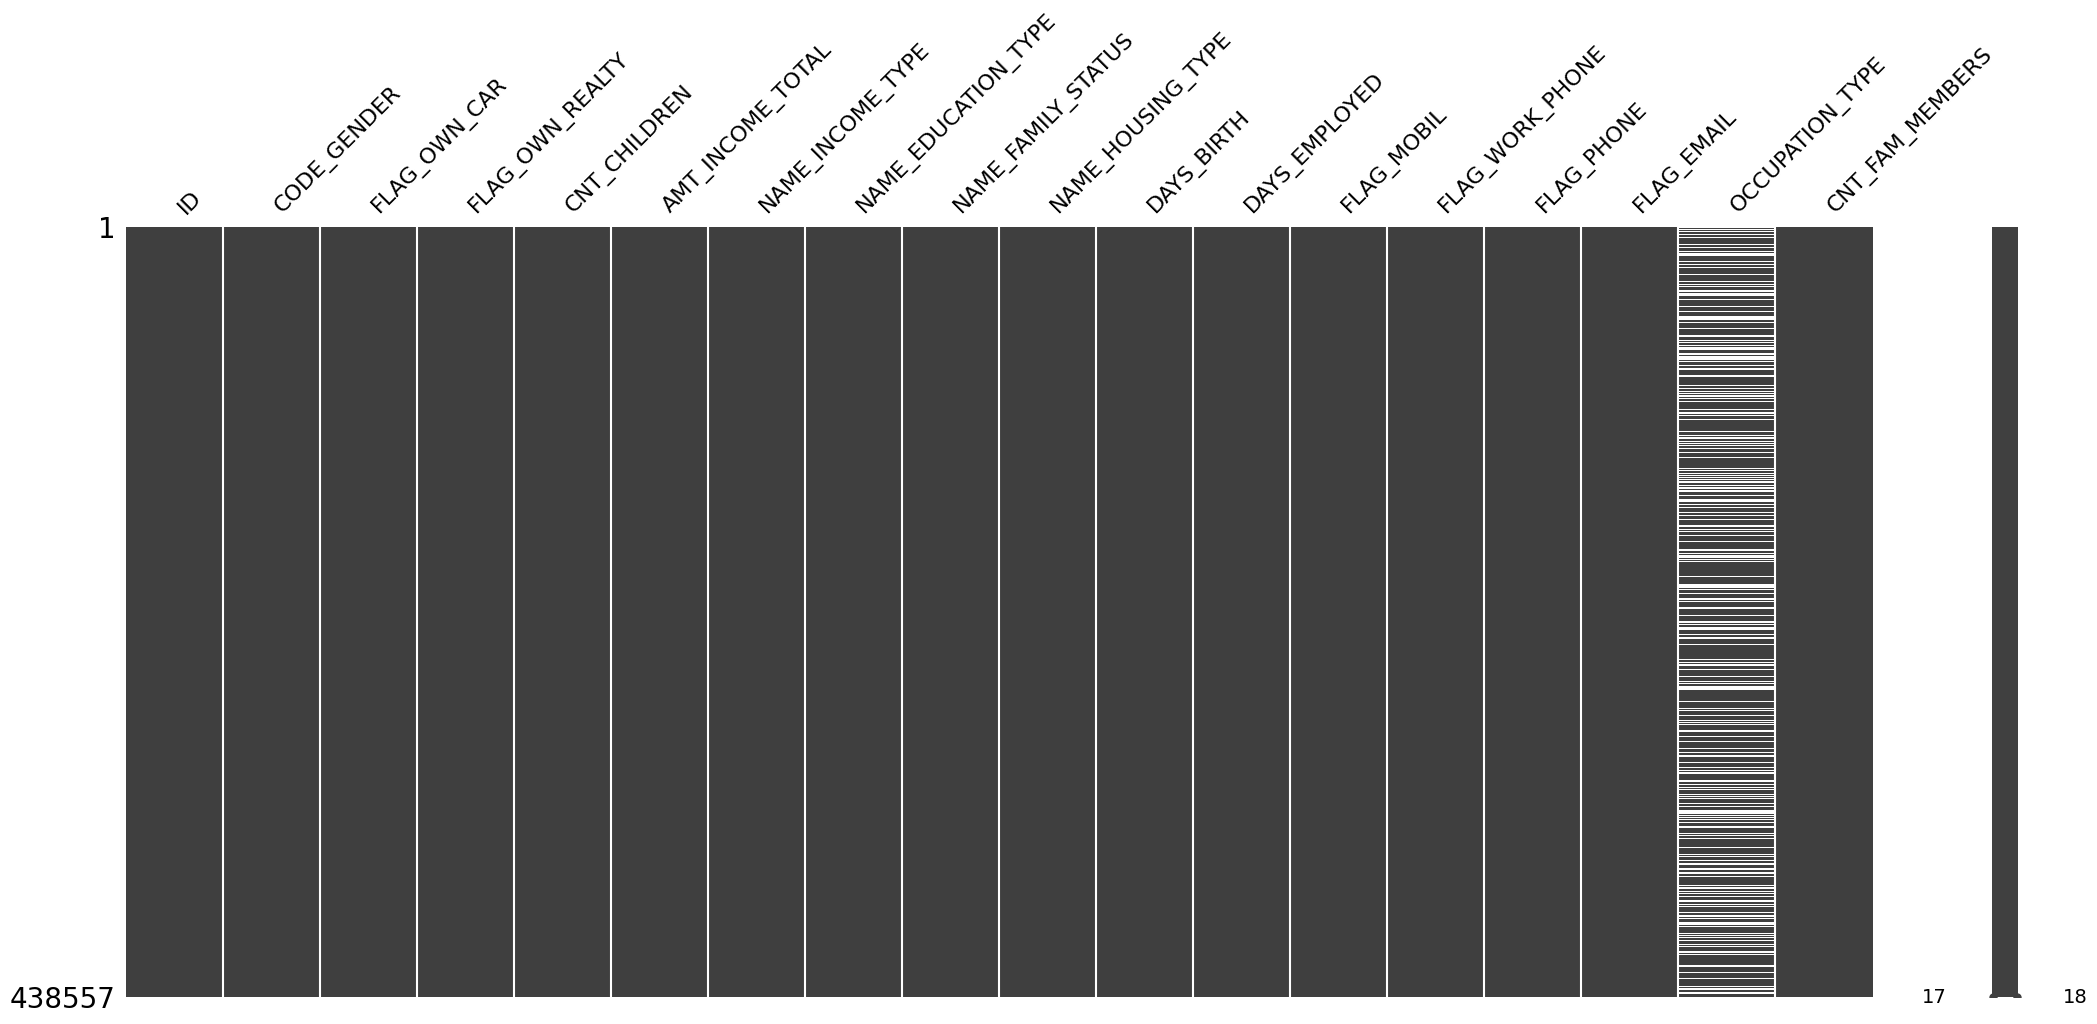

In [91]:
msno.matrix(full_data)
plt.show()

### Split data to training, testing and creating data

In [92]:
def data_split(df, testsize):
    train_df, test_df = train_test_split(df, test_size=testsize, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [93]:
train_original, test_original = data_split(credit_full_data, 0.2)

In [94]:
train_original.shape

(29165, 20)

In [95]:
test_original.shape

(7292, 20)

In [96]:
train_original.to_csv("train.csv", index= False)
test_original.to_csv("test.csv", index= False)

In [97]:
train_copy = train_original.copy()
test_copy = test_original.copy()

#### Exploxe the data
##### Data Profilting

In [98]:
# profile_report = ProfileReport(train_copy)
# profile_report_file_path = Path('./pandas_profile_file/credit_pred_profile.html')

# # checking if the pandas profile report file exists in the current directory
# try:
#     profile_report_file_path.resolve(strict=True)
# except FileNotFoundError:
#     profile_report.to_file("./pandas_profile_file/credit_pred_profile.html")


# profile = ProfileReport(
#     train_prep
# )
# profile.to_file("./pandas_profile_file/credit_pred_profile.html")

### 2. Funtction used each features

In [99]:
#Function trả về giá trị và tần số tương ứng của chúng
def value_count_norm_call(df, feature):
    frt_value_count = df[feature].value_counts()
    frt_value_count_norm = df[feature].value_counts(normalize=True) * 100
    frt_value_concat = pd.concat([frt_value_count, frt_value_count_norm], axis = 1)
    frt_value_concat.columns = ['Count', 'Frequency (%)']
    return frt_value_concat

In [100]:
def get_info(df, feature):
    if feature == 'Age':
            print('Description:\n{}'.format((np.abs(df[feature])/365).describe()))
            print('*'*50)
            print('Object type:{}'.format(df[feature].dtype))
    elif feature== 'Employment length':
           # chỉ chọn ra các người còn làm việc và bỏ qua những người đã nghỉ việc
            employment_len_no_ret = train_copy['Employment length'][train_copy['Employment length'] < 0]
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365
            print('Description:\n{}'.format((employment_len_no_ret_yrs).describe()))
            print('*'*50)
            print('Object type:{}'.format(employment_len_no_ret))
    elif feature =='Account age':
            # Thay đổi thời gian thành số dương
            print('Description:\n{}'.format((np.abs(df[feature])).describe()))
            print('*'*50)
            print('Object type:{}'.format(df[feature].dtype))
    else:
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            value_cnt = value_count_norm_call(df,feature)
            print('Value count:\n{}'.format(value_cnt))

In [101]:
# Function tạo biểu đồ hình tròn

def creat_pie_plot(df, feature):
    if feature == 'Drewlling' or 'Education level':
        ratio_size = value_count_norm_call(df, feature)
        ratio_size_len = len(ratio_size.index)
        ratio_list = []
        for i in range(ratio_size_len):
            ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
        fig, ax = plt.subplots(figsize=(8,8))
        # 1.2f %% hiển thị số thập phân trong biểu đồ hình tròn với 2 chữ số thập phân
        plt.pie(ratio_list, startangle=90, wedgeprops={'edgecolor' :'black'})
        plt.title('Pie chart of {}'.format(feature))
        plt.legend(loc='best',labels = ratio_size.index[0])
        plt.axis('equal')
        return plt.show()
    else :
        ratio_size = value_count_norm_call(df, feature)
        ratio_size_len = len(ratio_size.index)
        ratio_list = []
        for i in range(ratio_size_len):
            ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
        fig, ax = plt.subplots(figsize=(8,8))
        # %1.2f%% display decimals in the pie chart with 2 decimal places
        plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' :'black'})
        plt.title('Pie chart of {}'.format(feature))
        plt.legend(loc='best')
        plt.axis('equal')
        return plt.show()

In [102]:
#function để tạo ra các bar chart
def creat_bar_chart(df, feature):
    if feature == 'Marital status' or 'Dwelling' or 'Job title'or 'Employment status' or 'Education level':
        fig, ax = plt.subplots(figsize=(6,10))
        sns.barplot(x=value_count_norm_call(df,feature).index,y=value_count_norm_call(df,feature).values[:,0])
        ax.set_xticklabels(labels=value_count_norm_call(df,feature).index,rotation=45,ha='right')
        plt.xlabel('{}'.format(feature))
        plt.ylabel('Count')
        plt.title('{} count'.format(feature))
        return plt.show()
    else:
        fig, ax = plt.subplots(figsize=(6,10))
        sns.barplot(x=value_count_norm_call(df,feature).index,y=value_count_norm_call(df,feature).values[:,0])
        plt.xlabel('{}'.format(feature))
        plt.ylabel('Count')
        plt.title('{} count'.format(feature))
        return plt.show()

In [103]:
#Function để tạo bar chart
def creat_bar_plot(df, feature):
    if feature == 'Marital status' or 'Dwelling' or 'Job title' or 'Employment status' or 'Education level':
        fig, ax = plt.subplots(figsize =(6, 10))
        sns.barplot(x = value_count_norm_call(df, feature).index, y = value_count_norm_call(df, feature).values[:, 0])
        ax.set_xticklabels(labels = value_count_norm_call(df, feature).index, rotation=45, ha= 'right')
        plt.xlabel('{}'.format(feature))
        plt.ylabel('Count')
        plt.title('{}count'.format(feature))
        return plt.show()
    else:
        fig, ax = plt.subplots(figsize=(6,10))
        sns.barplot(x=value_count_norm_call(df,feature).index,y=value_count_norm_call(df,feature).values[:,0])
        plt.xlabel('{}'.format(feature))
        plt.ylabel('Count')
        plt.title('{} count'.format(feature))
        return plt.show()

In [104]:
#Function tạo box plot
def creat_box_plot(df, feature):
    if feature == 'Age':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y = np.abs(df[feature]/365))
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()
    elif feature == 'Children count':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=df[feature])
        plt.title('{} distribution(Boxplot)'.format(feature))
        plt.yticks(np.arange(0,df[feature].max(),1))
        return plt.show()
    elif feature == 'Employment length':
        fig, ax = plt.subplots(figsize=(2,8))
        employment_len_no_ret = train_copy['Employment length'][train_copy['Employment length'] < 0]
        employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
        sns.boxplot(y=employment_len_no_ret_yrs)
        plt.title('{} distribution(Boxplot)'.format(feature))
        plt.yticks(np.arange(0,employment_len_no_ret_yrs.max(),2))
        return plt.show()
    elif feature == 'Account age':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=np.abs(df[feature]))
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()
    else:
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=df[feature])
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()
        

In [105]:
def creat_hist_plot(df, feature, thebins=50):
    if feature == 'Age':
        fig, ax = plt.subplots(figsize= (18,10))
        sns.histplot(np.abs(df[feature]/365.25),bins= thebins)
        plt.title("{}distribution".format(feature))
        return plt.show()
    elif feature == 'Income':
        fig, ax = plt.subplots(figsize=(18, 10))
        sns.histplot(df[feature], bins= thebins)
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x),"," )))
        plt.title('{} distribution'.format(feature))
        return plt.show()
    elif feature == 'Account age':
        fig, ax = plt.subplots(18,10)
        sns.histplot(np.abs(df[feature], bins= thebins))
        plt.title("{}distribution".format(feature))
        return plt.show()
    else:
        fig, ax = plt.subplots(18,10)
        sns.histplot(df[feature], bins= thebins)
        plt.title("{}distribution".format(feature))
        return plt.show()

In [106]:
#Funcition tính độ rủi ro
def low_high_risk_bar_plot(df, feature):
    is_high_risk_grp = df.groupby(feature)['Is high risk'].sum()
    is_high_risk_srt = is_high_risk_grp.sort_values(ascending= True)
    print(is_high_risk_srt)
    fig, ax = plt.subplots(figsize=(6, 10))
    sns.barplot(x= is_high_risk_srt.index, y = is_high_risk_srt.values)
    ax.set_xticklabels(labels =  is_high_risk_srt.index)
    plt.ylabel('Count')
    plt.title("High risk appliacants count by high risk{}".format(feature))
    return plt.show()

# Phân tích đơn biến

## Gender

In [107]:
get_info(train_copy, "Gender")

Description:
count     29165
unique        2
top           F
freq      19549
Name: Gender, dtype: object
**************************************************
Object type:
object
Value count:
   Count  Frequency (%)
F  19549         $67.03
M   9616         $32.97


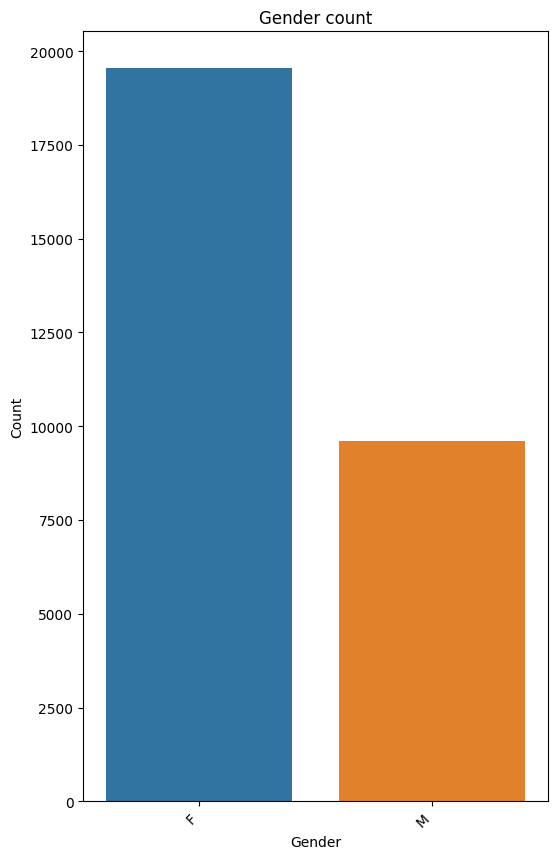

In [108]:
creat_bar_chart(train_copy, "Gender")

<li>Số nhân viên nam chiếm đa số với 19000 nhân viên</li>
<li> Số nhân viên nữ chiếm thiểu số với 9600 nhân viên </li>

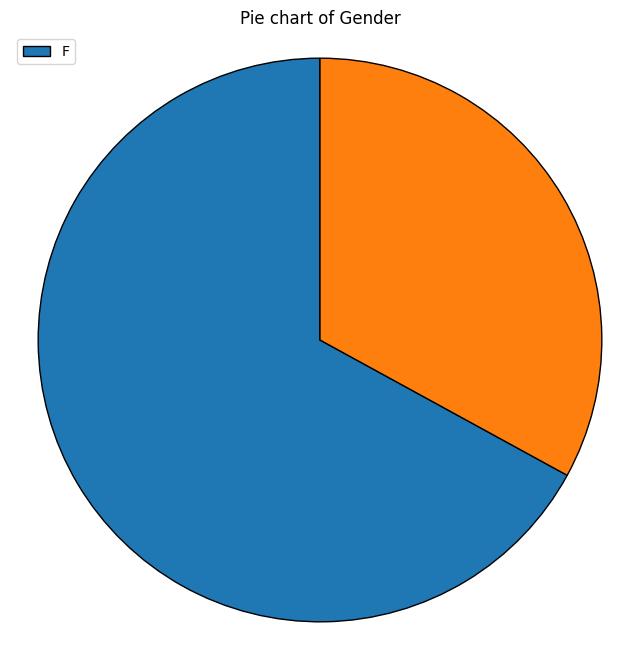

In [109]:
creat_pie_plot(train_copy, 'Gender')

<li>Nhân viên nam chiếm đa số với 63% </li>
<li>Nhân viên nữ chiếm thiểu số với 37% </li>

## Age

In [110]:
get_info(train_copy, 'Age')

Description:
count   $29,165.00
mean        $43.78
std         $11.52
min         $21.11
25%         $34.18
50%         $42.64
75%         $53.27
max         $68.91
Name: Age, dtype: float64
**************************************************
Object type:int64


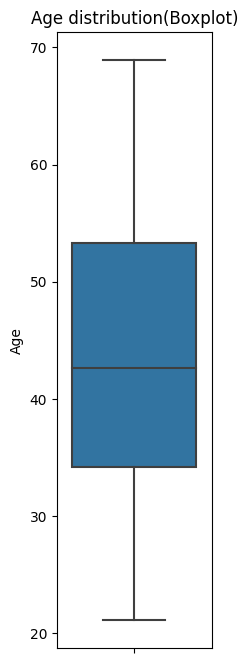

In [111]:
creat_box_plot(train_copy, 'Age')

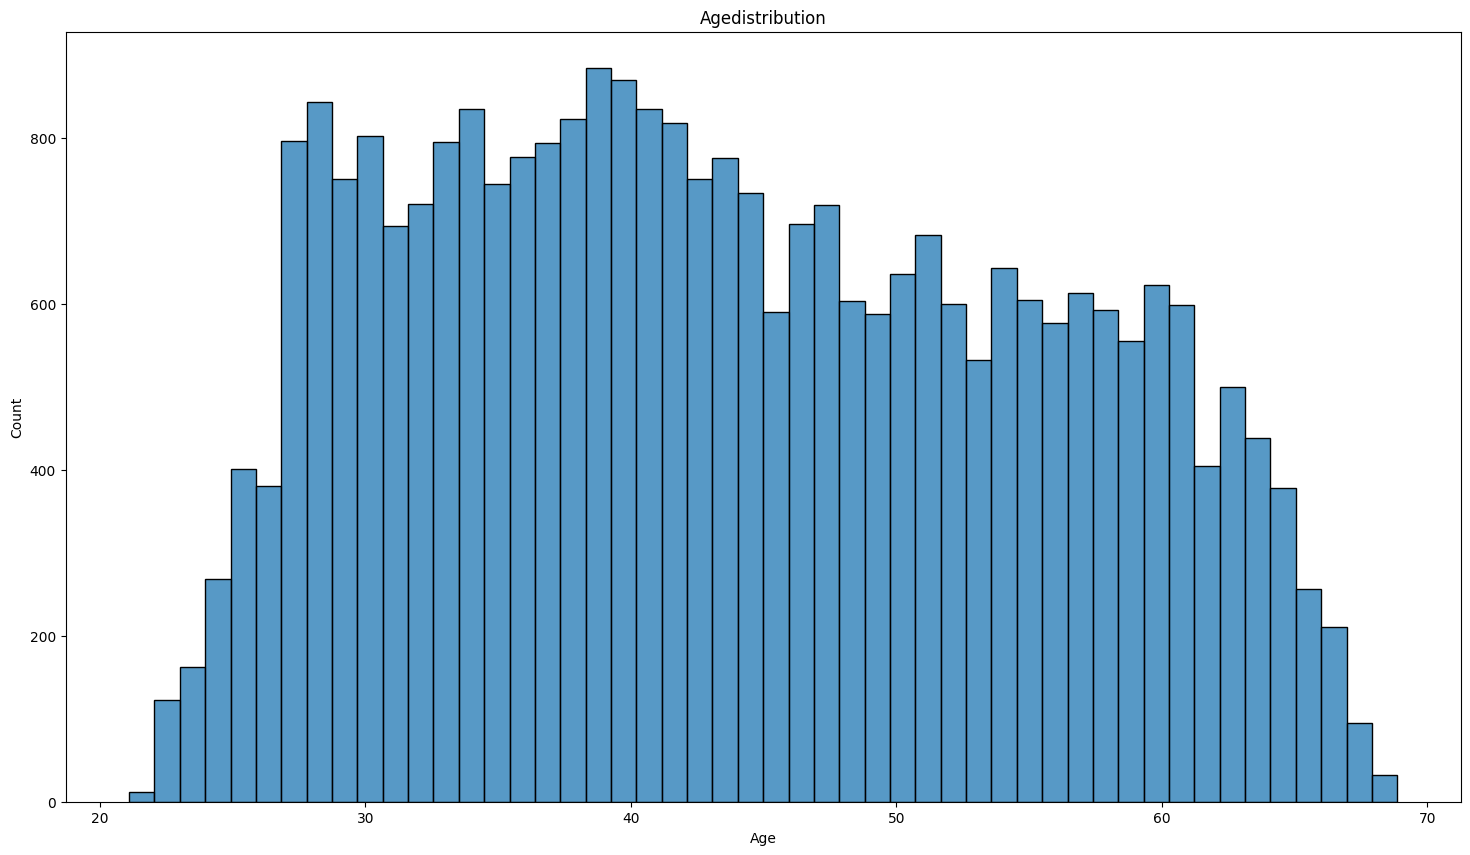

In [112]:
creat_hist_plot(train_copy, 'Age')

<li>Độ tuổi phổ biến của công ty là khoảng 28-42 tuổi</li>

#### Marital status

In [113]:
get_info(train_copy, 'Marital status')

Description:
count       29165
unique          5
top       Married
freq        20044
Name: Marital status, dtype: object
**************************************************
Object type:
object
Value count:
                      Count  Frequency (%)
Married               20044         $68.73
Single / not married   3864         $13.25
Civil marriage         2312          $7.93
Separated              1712          $5.87
Widow                  1233          $4.23


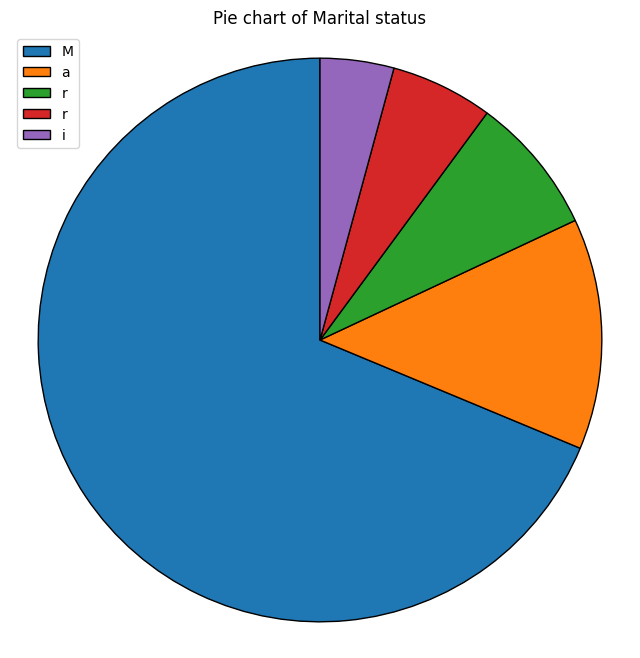

In [114]:
creat_pie_plot(train_copy, 'Marital status')

<li>Tình trạng hôn nhân chủ yếu công ty là Đã kết hôn chiếm tỉ trọng 68%</li>
<li>Tình trạng hôn nhân phổ biến thứ hai của công ty là độc thân/ chưa kết hôn chiếm tỉ trọng 13% </li>

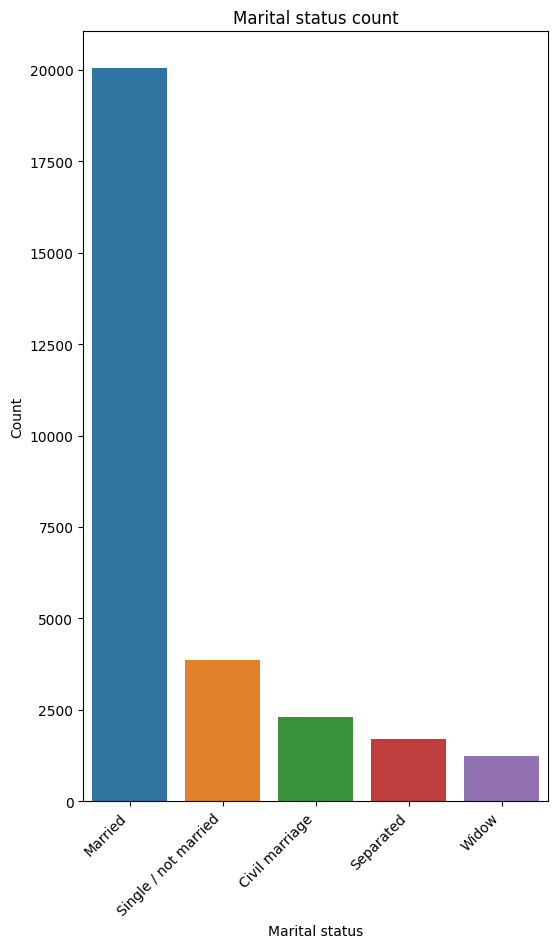

In [115]:
creat_bar_chart(train_copy, 'Marital status')

### Family member count

In [116]:
get_info(train_copy, 'Family member count')

Description:
count   $29,165.00
mean         $2.20
std          $0.91
min          $1.00
25%          $2.00
50%          $2.00
75%          $3.00
max         $20.00
Name: Family member count, dtype: float64
**************************************************
Object type:
float64
Value count:
        Count  Frequency (%)
$2.00   15552         $53.32
$1.00    5613         $19.25
$3.00    5121         $17.56
$4.00    2503          $8.58
$5.00     309          $1.06
$6.00      48          $0.16
$7.00      14          $0.05
$9.00       2          $0.01
$15.00      2          $0.01
$20.00      1          $0.00


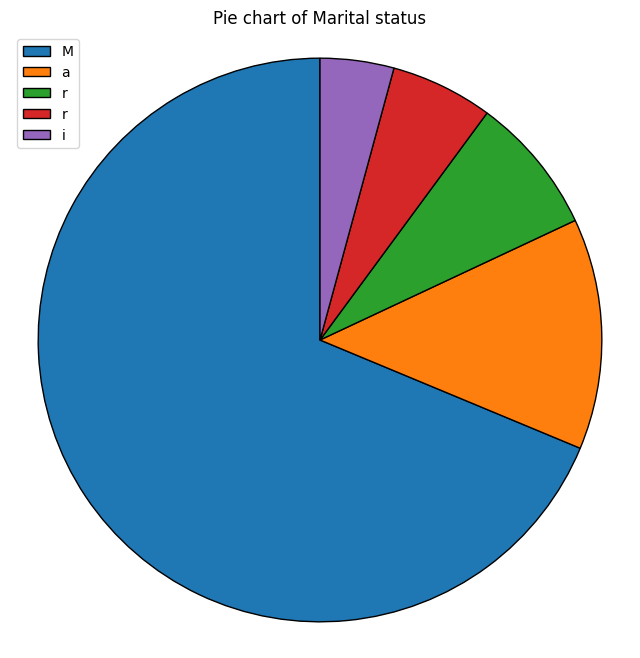

In [117]:
creat_pie_plot(train_copy, 'Marital status')

Marital status
Separated                24
Civil marriage           34
Widow                    34
Single / not married     87
Married                 320
Name: Is high risk, dtype: object


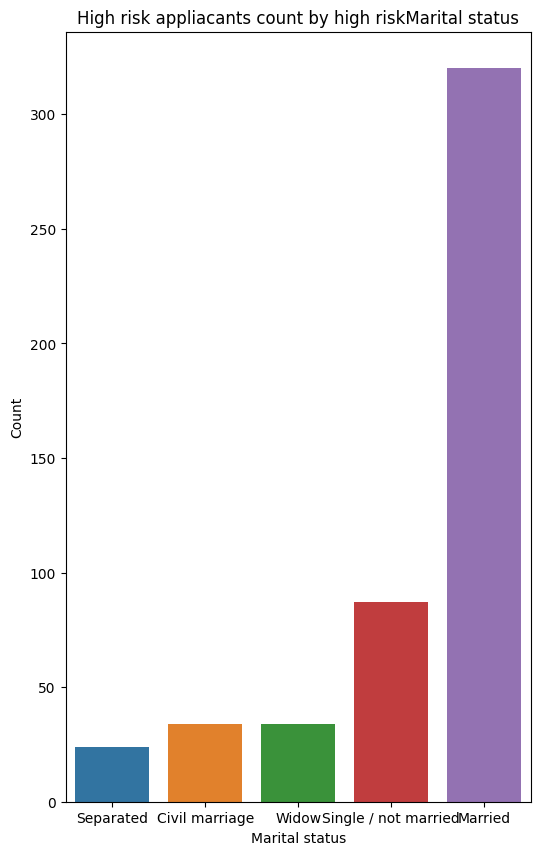

In [118]:
low_high_risk_bar_plot(train_copy, 'Marital status')

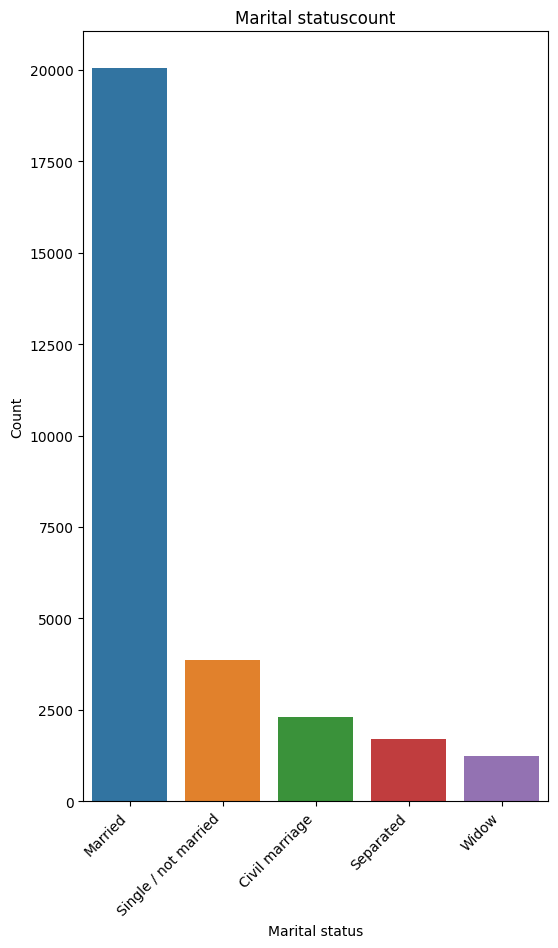

In [119]:
creat_bar_plot(train_copy, 'Marital status')

### Childern count

In [120]:
get_info(train_copy, 'Children count')

Description:
count   $29,165.00
mean         $0.43
std          $0.74
min          $0.00
25%          $0.00
50%          $0.00
75%          $1.00
max         $19.00
Name: Children count, dtype: float64
**************************************************
Object type:
int64
Value count:
    Count  Frequency (%)
0   20143         $69.07
1    6003         $20.58
2    2624          $9.00
3     323          $1.11
4      52          $0.18
5      15          $0.05
7       2          $0.01
14      2          $0.01
19      1          $0.00


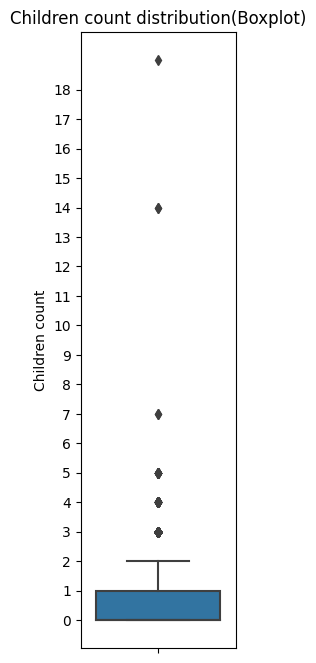

In [121]:
creat_box_plot(train_copy, 'Children count')

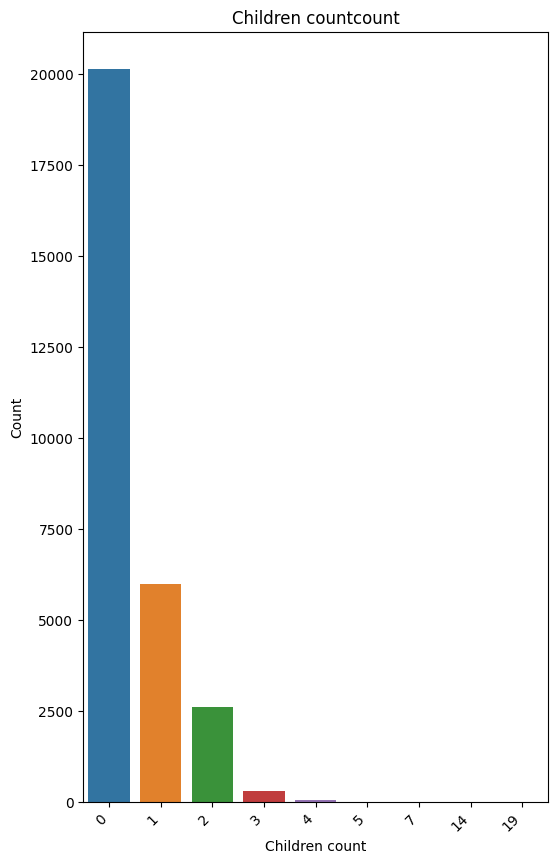

In [122]:
creat_bar_plot(train_copy, 'Children count')

### Drewlling type

In [123]:
get_info(train_copy, "Dwelling")

Description:
count                 29165
unique                    6
top       House / apartment
freq                  26059
Name: Dwelling, dtype: object
**************************************************
Object type:
object
Value count:
                     Count  Frequency (%)
House / apartment    26059         $89.35
With parents          1406          $4.82
Municipal apartment    912          $3.13
Rented apartment       453          $1.55
Office apartment       208          $0.71
Co-op apartment        127          $0.44


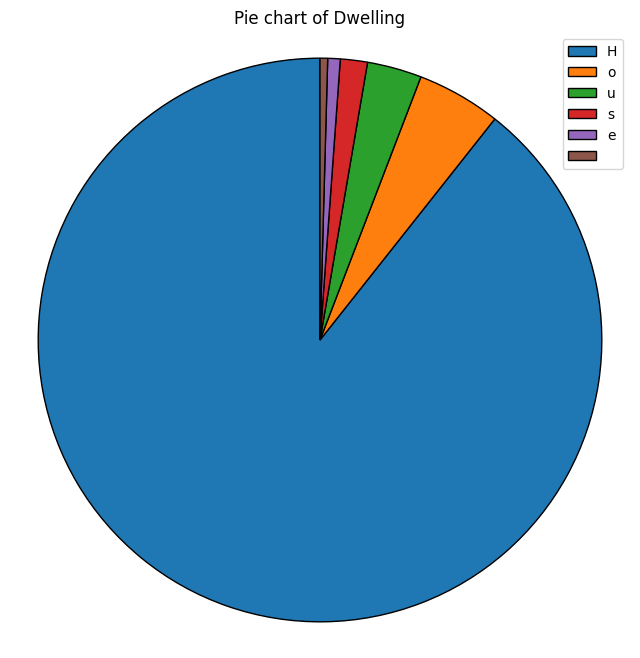

In [124]:
creat_pie_plot(train_copy, "Dwelling")

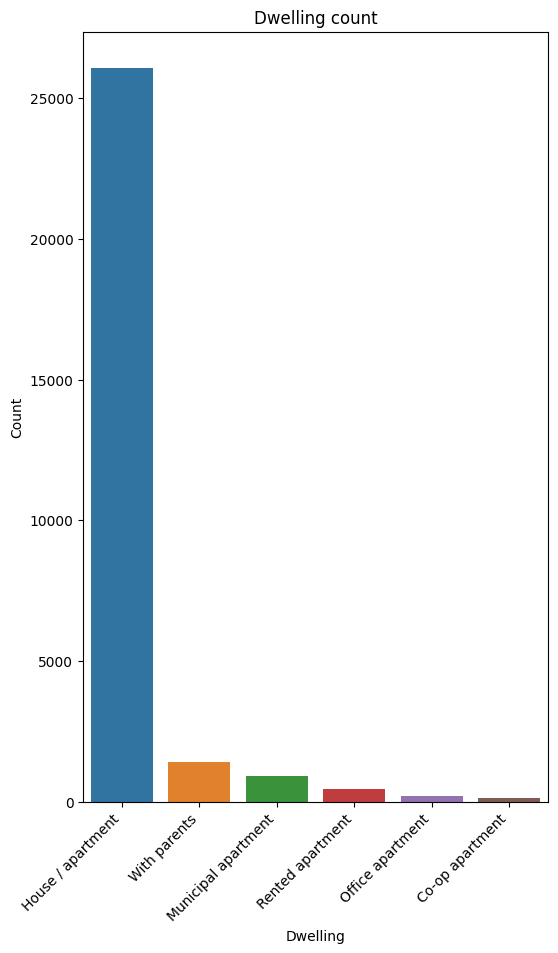

In [125]:
creat_bar_chart(train_copy, "Dwelling")

### Income

In [126]:
pd.options.display.float_format = '${:,.2f}'.format
get_info(train_copy, "Income")

Description:
count      $29,165.00
mean      $186,890.39
std       $101,409.64
min        $27,000.00
25%       $121,500.00
50%       $157,500.00
75%       $225,000.00
max     $1,575,000.00
Name: Income, dtype: float64
**************************************************
Object type:
float64
Value count:
             Count  Frequency (%)
$135,000.00   3468         $11.89
$180,000.00   2487          $8.53
$157,500.00   2469          $8.47
$225,000.00   2373          $8.14
$112,500.00   2359          $8.09
...            ...            ...
$164,250.00      1          $0.00
$42,300.00       1          $0.00
$432,000.00      1          $0.00
$145,350.00      1          $0.00
$82,350.00       1          $0.00

[259 rows x 2 columns]


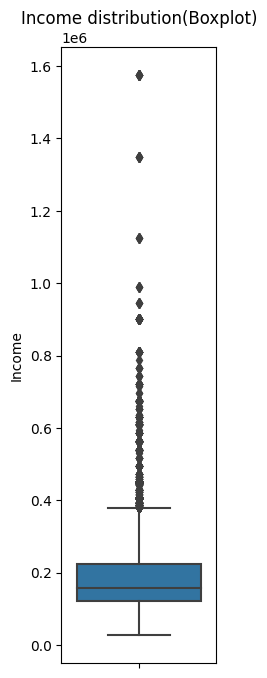

In [127]:
creat_box_plot(train_copy, "Income")

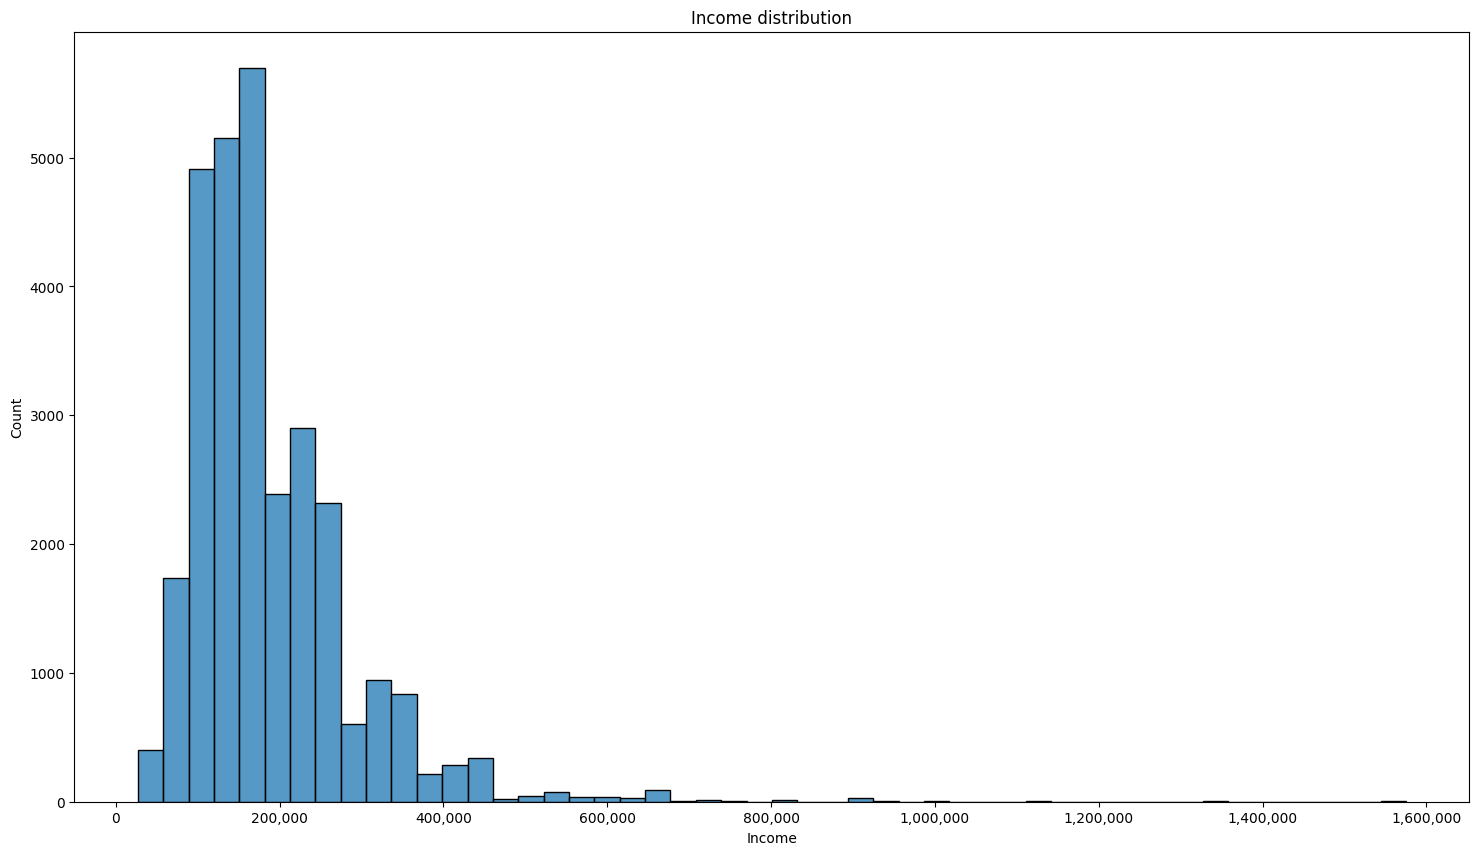

In [128]:
creat_hist_plot(train_copy, "Income")

### Job title

In [129]:
get_info(train_copy, "Job title")

Description:
count        20138
unique          18
top       Laborers
freq          5004
Name: Job title, dtype: object
**************************************************
Object type:
object
Value count:
                       Count  Frequency (%)
Laborers                5004         $24.85
Core staff              2866         $14.23
Sales staff             2773         $13.77
Managers                2422         $12.03
Drivers                 1722          $8.55
High skill tech staff   1133          $5.63
Accountants              998          $4.96
Medicine staff           956          $4.75
Cooking staff            521          $2.59
Security staff           464          $2.30
Cleaning staff           425          $2.11
Private service staff    287          $1.43
Low-skill Laborers       138          $0.69
Waiters/barmen staff     127          $0.63
Secretaries              122          $0.61
HR staff                  72          $0.36
Realty agents             60          $0.30
IT s

In [130]:
job_titile_nn_count = train_copy['Job title'].isna().sum()
job_titile_nn_count

9027

In [131]:
rows_total_count = train_copy.shape[0]
rows_total_count

29165

In [132]:
print('The percentage of missing rows is {:.2f} %'.format(job_titile_nn_count * 100 / rows_total_count))

The percentage of missing rows is 30.95 %


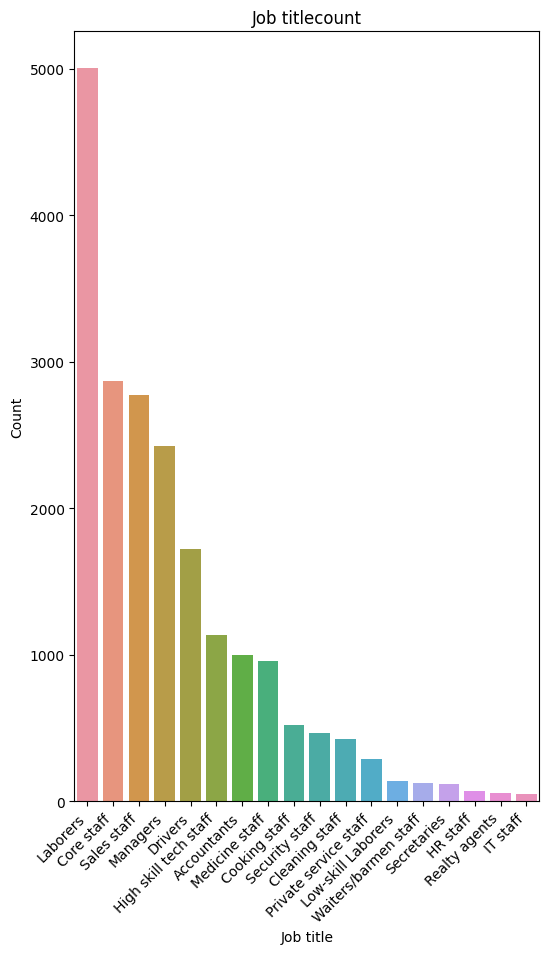

In [133]:
creat_bar_plot(train_copy, 'Job title')

### Employment status

In [134]:
get_info(train_copy, 'Employment status')

Description:
count       29165
unique          5
top       Working
freq        15056
Name: Employment status, dtype: object
**************************************************
Object type:
object
Value count:
                      Count  Frequency (%)
Working               15056         $51.62
Commercial associate   6801         $23.32
Pensioner              4920         $16.87
State servant          2381          $8.16
Student                   7          $0.02


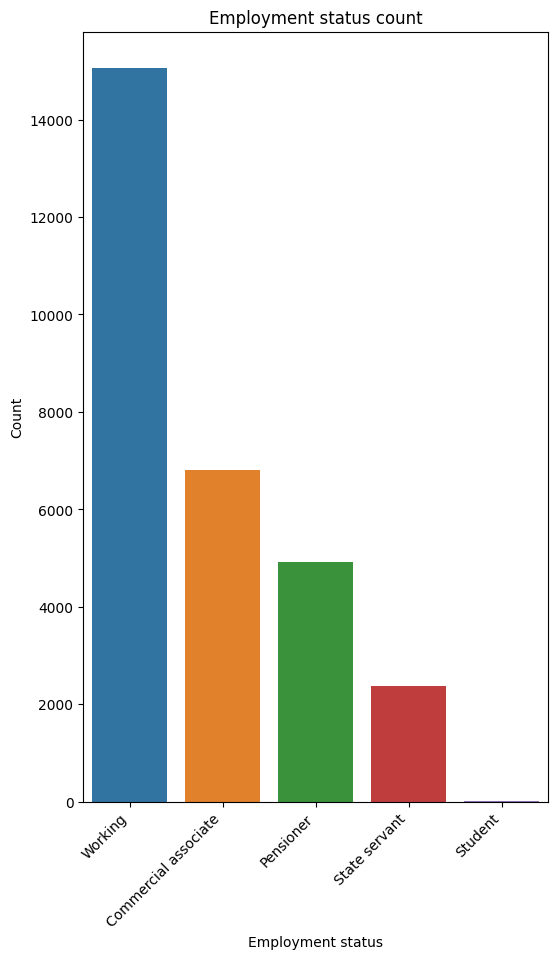

In [135]:
creat_bar_chart(train_copy, 'Employment status')

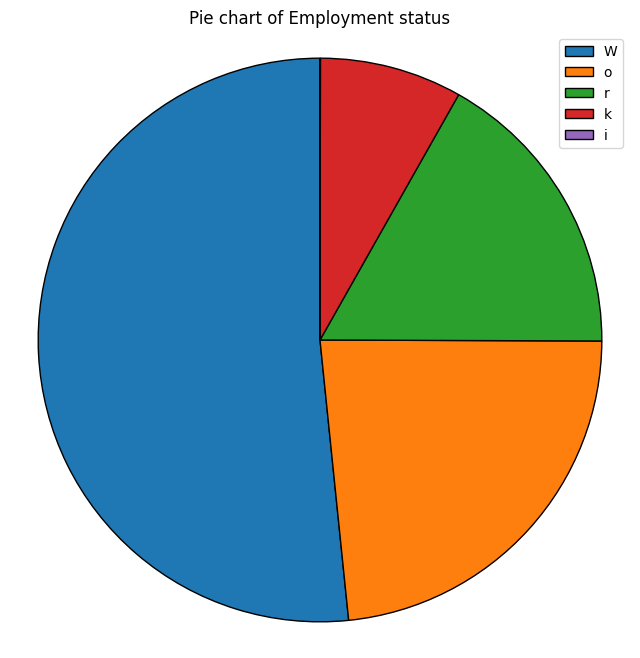

In [136]:
creat_pie_plot(train_copy, 'Employment status')

### Education level

In [137]:
get_info(train_copy, 'Education level')

Description:
count                             29165
unique                                5
top       Secondary / secondary special
freq                              19803
Name: Education level, dtype: object
**************************************************
Object type:
object
Value count:
                               Count  Frequency (%)
Secondary / secondary special  19803         $67.90
Higher education                7910         $27.12
Incomplete higher               1129          $3.87
Lower secondary                  298          $1.02
Academic degree                   25          $0.09


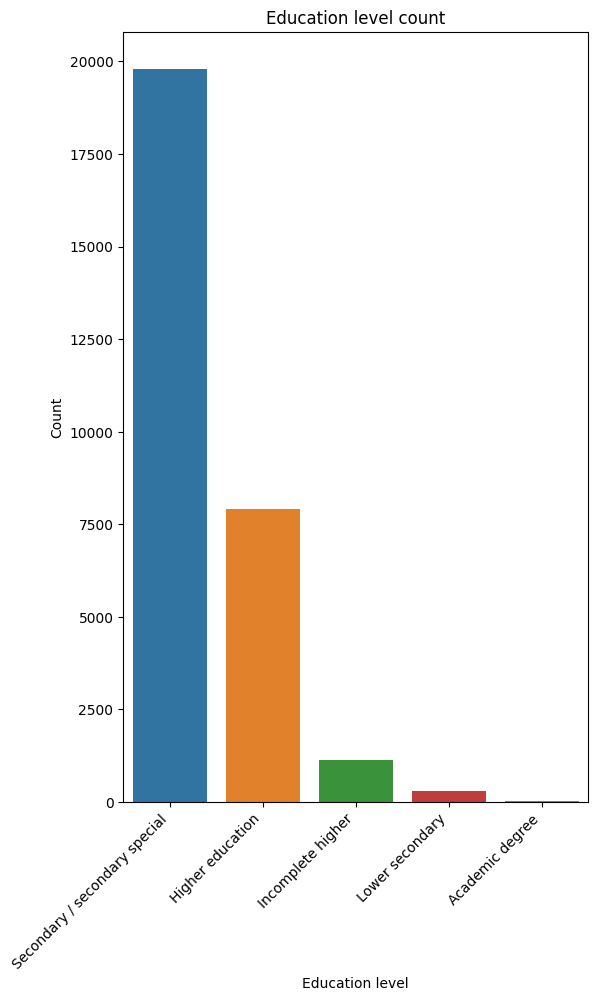

In [138]:
creat_bar_chart(train_copy, 'Education level')

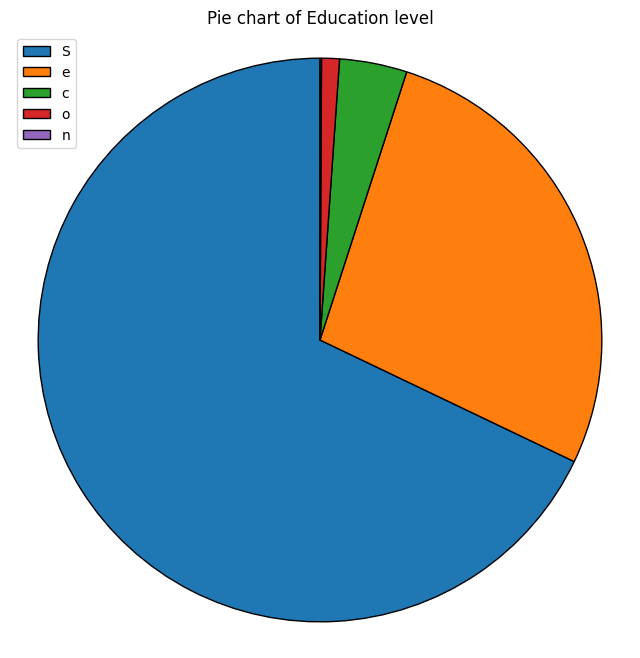

In [139]:
creat_pie_plot(train_copy, 'Education level')

### Employment length

In [140]:
get_info(train_copy, 'Employment length')

Description:
count   $24,257.00
mean         $7.27
std          $6.47
min          $0.05
25%          $2.68
50%          $5.45
75%          $9.61
max         $43.05
Name: Employment length, dtype: float64
**************************************************
Object type:0       -3111
1       -1651
2       -5657
3       -2046
4        -515
         ... 
29158   -2482
29159   -1447
29161   -8256
29162   -3291
29164   -2010
Name: Employment length, Length: 24257, dtype: int64


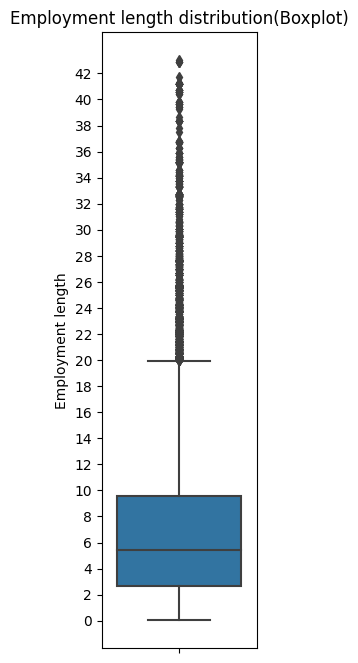

In [141]:
creat_box_plot(train_copy, 'Employment length')

### Has a car

In [142]:
get_info(train_copy, 'Has a car')

Description:
count     29165
unique        2
top           N
freq      18128
Name: Has a car, dtype: object
**************************************************
Object type:
object
Value count:
   Count  Frequency (%)
N  18128         $62.16
Y  11037         $37.84


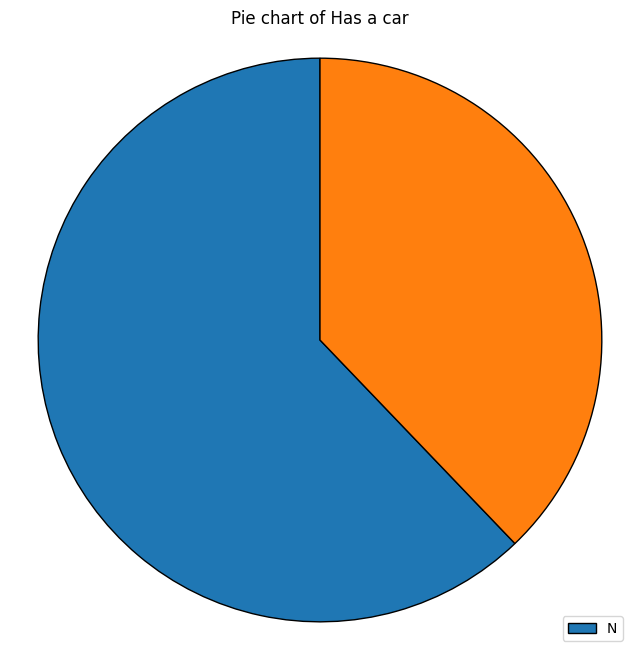

In [143]:
creat_pie_plot(train_copy,'Has a car')

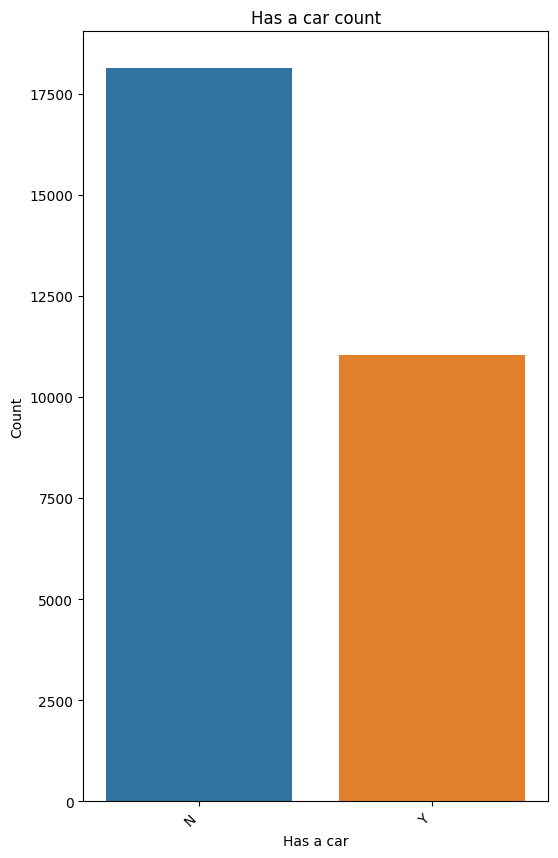

In [144]:
creat_bar_chart(train_copy, 'Has a car')

### Has a property

In [145]:
get_info(train_copy, 'Has a property')

Description:
count     29165
unique        2
top           Y
freq      19557
Name: Has a property, dtype: object
**************************************************
Object type:
object
Value count:
   Count  Frequency (%)
Y  19557         $67.06
N   9608         $32.94


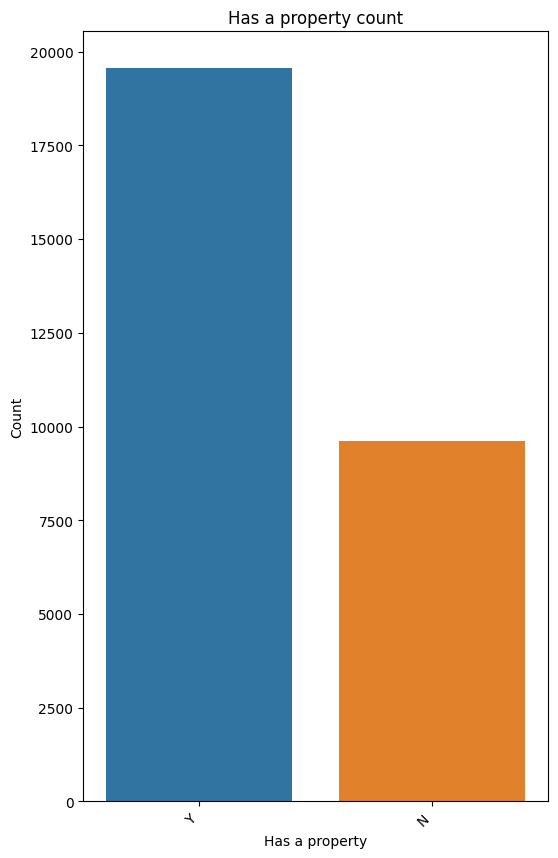

In [146]:
creat_bar_chart(train_copy, 'Has a property')

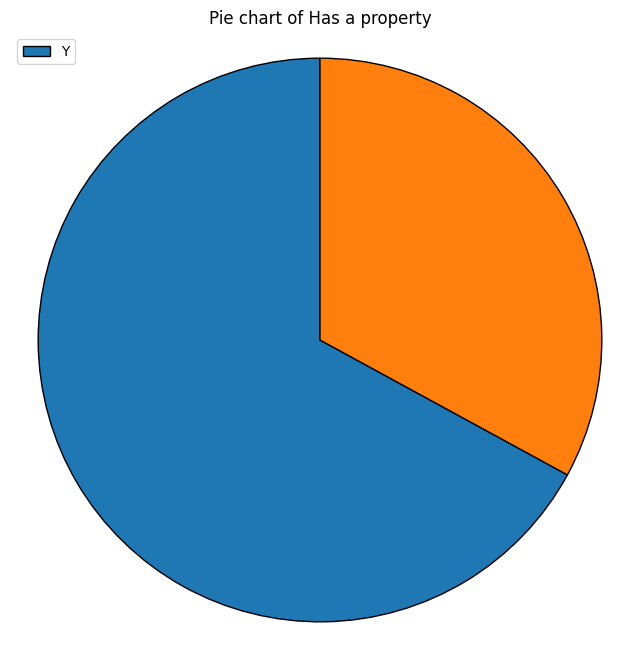

In [147]:
creat_pie_plot(train_copy, 'Has a property')

### Has a work phone

In [148]:
get_info(train_copy, 'Has a phone')

Description:
count   $29,165.00
mean         $0.29
std          $0.46
min          $0.00
25%          $0.00
50%          $0.00
75%          $1.00
max          $1.00
Name: Has a phone, dtype: float64
**************************************************
Object type:
int64
Value count:
   Count  Frequency (%)
0  20562         $70.50
1   8603         $29.50


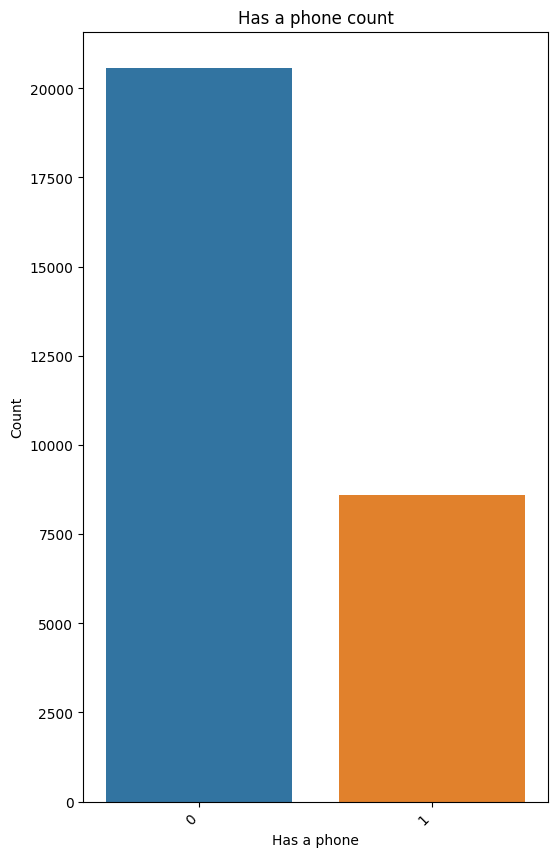

In [149]:
creat_bar_chart(train_copy, 'Has a phone')

In [150]:
# creat_pie_plot(train_copy, 'Has a phone')

#### Has an email

In [151]:
get_info(train_copy, 'Has an email')

Description:
count   $29,165.00
mean         $0.09
std          $0.29
min          $0.00
25%          $0.00
50%          $0.00
75%          $0.00
max          $1.00
Name: Has an email, dtype: float64
**************************************************
Object type:
int64
Value count:
   Count  Frequency (%)
0  26532         $90.97
1   2633          $9.03


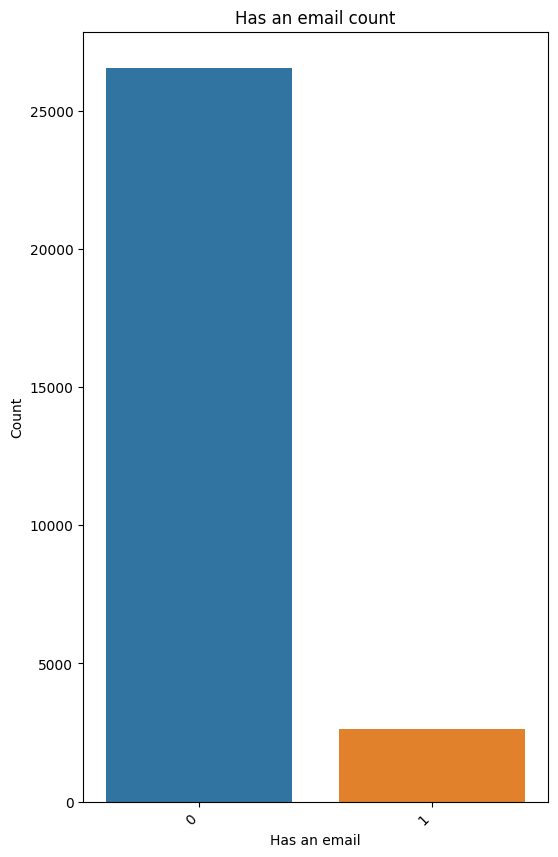

In [152]:
creat_bar_chart(train_copy, 'Has an email')

In [153]:
# creat_pie_plot(train_copy, 'Has an email')

### Is high risk

In [154]:
get_info(train_copy, 'Is high risk')

Description:
count     29165
unique        2
top           0
freq      28666
Name: Is high risk, dtype: int64
**************************************************
Object type:
object
Value count:
   Count  Frequency (%)
0  28666         $98.29
1    499          $1.71


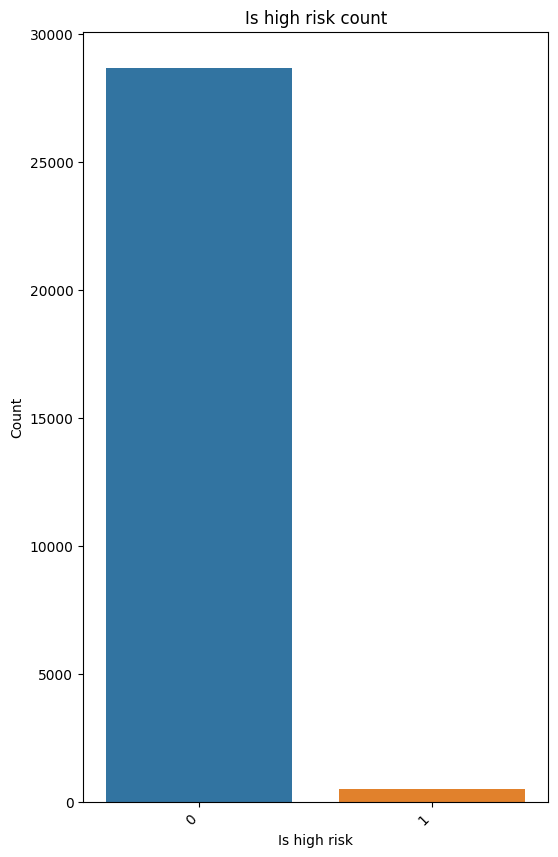

In [155]:
creat_bar_chart(train_copy, 'Is high risk')

In [156]:
# creat_pie_plot(train_copy, 'Is high risk')

### Chuẩn bị dữ liệu

<ul>ID<br>
    <li>Remove feature </li>
</ul>
<ul>Gender<br>
    <li>On hot conding </li>
</ul>
<ul>Age<br>
    <li>Min max scalling </li>
    <li>Fix skewnes </li>
    <li>Abs value and div </li>
</ul>
<ul>
Martial status<br>
    <li> On hot coding </li>
</ul>
<ul>Children count<br>
    <li> Fix outliers </li>
    <li> Drop features </li>
</ul>
<ul>Dwelling type<br>
    <li> On hot encoding </li>
</ul>
<ul>
Income<br>
    <li> Remove outliers </li>
    <li> Fix skewness </li>
    <li> Min max scalling </li>
</ul>
<ul>Job titile<br>
    <li>  On hot conding </li>
    <li> Fill  missing values </li>
</ul>

<ul>Employment status<br>
    <li> Order by enconding </li>
</ul>

<ul>Employment length<br>
    <li>Remove outliers</li>
    <li>Min-max scaling</li>
    <li>Abs value and div 365.25</li>
    <li>change days of employments of retirees to 0</li>
</ul>
<ul>Has a car <br>
    <li>Change it numerical</li>
    <li>One-hot encoding</li>
</ul>

<ul>Has a property: <br>
    <li>Change it numerical</li>
    <li>One-hot encoding</li>
</ul>

<ul>Has a mobile phone: <br>
    <li>Drop feature</li>
</ul>
<ul>Has a work phone: <br>
    <li>One-hot encoding</li>
</ul>
<ul>Has a phone<br>
    <li>One-hot encoding</li>
</ul>
<ul>Has a email: <br>
    <li>One-hot encoding</li>
</ul>
<ul>Account age: <br>
    <li>Drop table</li>
</ul>
<ul>
Is high risk(Target):<br>
    <li>Change the data type to numerical</li>
    <li> balance the data with SMOTE</li>
</ul>

#### 3.1 Data selection
##### 3.1.1 Drop features

In [157]:
class DropFeatures(BaseEstimator,TransformerMixin):
    def __init__(self,feature_to_drop = ['ID','Has a mobile phone','Children count','Job title','STATUS']):  #Account age
        self.feature_to_drop = feature_to_drop
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feature_to_drop).issubset(df.columns)):
            df.drop(self.feature_to_drop,axis=1,inplace=True)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

Tại sao ta có thể bỏ một số thuộc tính như trên đi?
<li> ID: ID không có tác dụng trong việc dự đoán dữ liệu, nó chỉ giúp ta truy xuất dữ liệu và gộp các bảng lại</li>
<li> Has a mobile phone: Hầu hết ai cũng có một điện thoại nên dữ liệu không giúp ích được gì lắm</li>
<li>Children count: có độ tương quan cao với Family count nên ta chỉ giữ lại một dữ liệu để dự đoán </li>
<li>Job title:Dữ liệu bị thiếu quá nhiều và nghề nghiệp không đa dạng lắm tập trung chủ yếu ở một số nghề </li>
<li> Account age : Thông tin không giúp ích được nhiều để dự báo tín dụng </li>

### 3.2 Feature engineerging
#### 3.2.1 Time conversion

In [158]:
class TimeConversionHandler(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_days = ['Employment length', 'Age']):
        self.feat_with_days = feat_with_days
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if (set(self.feat_with_days).issubset(X.columns)):
            # convert days to absolute value
            X[['Employment length','Age']] = np.abs(X[['Employment length','Age']])
            return X
        else:
            print("One or more features are not in the dataframe")
            return X

#### 3.2.2 Retiree handling (in employment length)

In [159]:
class RetireeHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, df):
        return self
    def transform(self, df):
        if 'Employment length' in df.columns:
            # select rows with employment length is 365243 which corresponds to retirees
            df_ret_idx = df['Employment length'][df['Employment length'] == 365243].index
            # change 365243 to 0
            df.loc[df_ret_idx,'Employment length'] = 0
            return df
        else:
            print("Employment length is not in the dataframe")
            return df

##### 3.2.3 Skeness Handling

In [160]:
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_skewness=['Income','Age']):
        self.feat_with_skewness = feat_with_skewness
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_skewness).issubset(df.columns)):
            # Handle skewness with cubic root transformation
            df[self.feat_with_skewness] = np.cbrt(df[self.feat_with_skewness])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

#### 3.2.4 Bining

In [161]:
class BinningNumToYN(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_num_enc=['Has a work phone','Has a phone','Has an email']):
        self.feat_with_num_enc = feat_with_num_enc
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_num_enc).issubset(df.columns)):
            # Change 0 to N and 1 to Y for all the features in feat_with_num_enc
            for ft in self.feat_with_num_enc:
                df[ft] = df[ft].map({1:'Y',0:'N'})
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

#### 3.2.5 On hot encoding

In [163]:
class OneHotWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,one_hot_enc_ft = ['Gender', 'Marital status', 'Dwelling', 'Employment status', 'Has a car', 'Has a property', 'Has a work phone', 'Has a phone', 'Has an email']):
        self.one_hot_enc_ft = one_hot_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.one_hot_enc_ft).issubset(df.columns)):
            # function to one hot encode the features in one_hot_enc_ft
            def one_hot_enc(df,one_hot_enc_ft):
                one_hot_enc = OneHotEncoder()
                one_hot_enc.fit(df[one_hot_enc_ft])
                # get the result of the one hot encoding columns names
                feat_names_one_hot_enc = one_hot_enc.get_feature_names_out(one_hot_enc_ft)
                # change the array of the one hot encoding to a dataframe with the column names
                df = pd.DataFrame(one_hot_enc.transform(df[self.one_hot_enc_ft]).toarray(),columns=feat_names_one_hot_enc,index=df.index)
                return df
            # function to concatenat the one hot encoded features with the rest of features that were not encoded
            def concat_with_rest(df,one_hot_enc_df,one_hot_enc_ft):
                # get the rest of the features
                rest_of_features = [ft for ft in df.columns if ft not in one_hot_enc_ft]
                # concatenate the rest of the features with the one hot encoded features
                df_concat = pd.concat([one_hot_enc_df, df[rest_of_features]],axis=1)
                return df_concat
            # one hot encoded dataframe
            one_hot_enc_df = one_hot_enc(df,self.one_hot_enc_ft)
            # returns the concatenated dataframe
            full_df_one_hot_enc = concat_with_rest(df,one_hot_enc_df,self.one_hot_enc_ft)
            return full_df_one_hot_enc
        else:
            print("One or more features are not in the dataframe")
            return df

#### 3.2.6 Ordinal encoding (with feature's names)

In [165]:
class OrdinalFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,ordinal_enc_ft = ['Education level']):
        self.ordinal_enc_ft = ordinal_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Education level' in df.columns:
            ordinal_enc = OrdinalEncoder()
            df[self.ordinal_enc_ft] = ordinal_enc.fit_transform(df[self.ordinal_enc_ft])
            return df
        else:
            print("Education level is not in the dataframe")
            return df

#### 3.27 Min Max scalling (with feature's name)

In [166]:
class MinMaxWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,min_max_scaler_ft = ['Age', 'Income', 'Employment length']):
        self.min_max_scaler_ft = min_max_scaler_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.min_max_scaler_ft).issubset(df.columns)):
            min_max_enc = MinMaxScaler()
            df[self.min_max_scaler_ft] = min_max_enc.fit_transform(df[self.min_max_scaler_ft])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

#### 3.28 Change the data types of the target features

In [167]:
class ChangeToNumTarget(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Is high risk' in df.columns:
            df['Is high risk'] = pd.to_numeric(df['Is high risk'])
            return df
        else:
            print("Is high risk is not in the dataframe")
            return df

#### 3.2.9 Oversampling

In [168]:
class Oversample(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Is high risk' in df.columns:
            # smote function to oversample the minority class to fix the imbalance data
            oversample = SMOTE(sampling_strategy='minority')
            X_bal, y_bal = oversample.fit_resample(df.loc[:, df.columns != 'Is high risk'],df['Is high risk'])
            df_bal = pd.concat([pd.DataFrame(X_bal),pd.DataFrame(y_bal)],axis=1)
            return df_bal
        else:
            print("Is high risk is not in the dataframe")
            return df

##### Chúng ta sử dụng cân bằng vì Is high risk = 1 quá hiếm trong data

#### 3.3 Data cleaning

#### 3.3.1 Outlier handling

In [169]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_outliers = ['Family member count','Income', 'Employment length']):
        self.feat_with_outliers = feat_with_outliers
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_outliers).issubset(df.columns)):
            # 25% quantile
            Q1 = df[self.feat_with_outliers].quantile(.25)
            # 75% quantile
            Q3 = df[self.feat_with_outliers].quantile(.75)
            IQR = Q3 - Q1
            # keep the data within 3 IQR
            df = df[~((df[self.feat_with_outliers] < (Q1 - 3 * IQR)) |(df[self.feat_with_outliers] > (Q3 + 3 * IQR))).any(axis=1)]
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

##### 3.4 Data preprocessing

In [173]:
def full_pieline(df):
    pipeline = Pipeline([
        ('outlier_remover', OutlierRemover()),
        ('feature_dropper', DropFeatures()),
        ('time_conversion_handler', TimeConversionHandler()),
        ('retiree_handler', RetireeHandler()),
        ('skewness_handler', SkewnessHandler()),
        ('binning_num_to_yn', BinningNumToYN()),
        ('one_hot_with_feat_names', OneHotWithFeatNames()),
        ('ordinal_feat_names', OrdinalFeatNames()),
        ('min_max_with_feat_names', MinMaxWithFeatNames()),
        # ('change_to_num_target', ChangeToNumTarget())
        ('oversample', Oversample())    
    ])
    df_pipe_prep = pipeline.fit_transform(df)
    return df_pipe_prep

In [174]:
pd.options.mode.chained_assignment = None  # Hide the copy warning
train_prep = full_pieline(train_copy)

ValueError: Unknown label type: 'unknown'

In [ ]:
pd.set_option('display.max_columns', None)
train_prep.head()

,Gender_F,Gender_M,Marital status_Civil marriage,Marital status_Married,Marital status_Separated,Marital status_Single / not married,Marital status_Widow,Dwelling_Co-op apartment,Dwelling_House / apartment,Dwelling_Municipal apartment,Dwelling_Office apartment,Dwelling_Rented apartment,Dwelling_With parents,Employment status_Commercial associate,Employment status_Pensioner,Employment status_State servant,Employment status_Student,Employment status_Working,Has a car_N,Has a car_Y,Has a property_N,Has a property_Y,Has a work phone_N,Has a work phone_Y,Has a phone_N,Has a phone_Y,Has an email_N,Has an email_Y,Income,Education level,Age,Employment length,Family member count,Is high risk
0,$0.00,$1.00,$0.00,$1.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$1.00,$0.00,$0.00,$0.00,$0.00,$1.00,$0.00,$1.00,$0.00,$1.00,$1.00,$0.00,$1.00,$0.00,$1.00,$0.00,$0.42,$4.00,$0.60,$0.27,$2.00,0
1,$1.00,$0.00,$0.00,$0.00,$0.00,$1.00,$0.00,$0.00,$1.00,$0.00,$0.00,$0.00,$0.00,$1.00,$0.00,$0.00,$0.00,$0.00,$0.00,$1.00,$1.00,$0.00,$1.00,$0.00,$1.00,$0.00,$1.00,$0.00,$0.42,$1.00,$0.20,$0.14,$2.00,0
2,$1.00,$0.00,$0.00,$1.00,$0.00,$0.00,$0.00,$0.00,$1.00,$0.00,$0.00,$0.00,$0.00,$1.00,$0.00,$0.00,$0.00,$0.00,$1.00,$0.00,$0.00,$1.00,$1.00,$0.00,$1.00,$0.00,$1.00,$0.00,$0.52,$4.00,$0.39,$0.50,$4.00,0
3,$1.00,$0.00,$0.00,$0.00,$0.00,$1.00,$0.00,$0.00,$1.00,$0.00,$0.00,$0.00,$0.00,$1.00,$0.00,$0.00,$0.00,$0.00,$0.00,$1.00,$0.00,$1.00,$1.00,$0.00,$1.00,$0.00,$0.00,$1.00,$0.81,$1.00,$0.84,$0.18,$1.00,0
4,$1.00,$0.00,$0.00,$0.00,$1.00,$0.00,$0.00,$0.00,$1.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$1.00,$1.00,$0.00,$1.00,$0.00,$1.00,$0.00,$0.00,$1.00,$1.00,$0.00,$0.68,$4.00,$0.60,$0.04,$1.00,0


In [ ]:
X = train_prep.drop(columns= ['Is high risk'])
y = train_prep['Is high risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)

In [ ]:
y = train_prep['Is high risk'].sum()

print(y)

401


#### Mô hình dự báo

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4659
           1       1.00      0.01      0.03        76

    accuracy                           0.98      4735
   macro avg       0.99      0.51      0.51      4735
weighted avg       0.98      0.98      0.98      4735



d:\Anaconda\envs\ai\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
